# Validación de modelo

In [1]:
import pandas as pd
import joblib
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Definiciones globales y funciones de transformación

%run ../Lib/pandas_options.py
%run ../Lib/define_constantes.py
%run ../Lib/fn_transformaciones.py

Fecha y Hora de ejecución de módulo: 2024-10-10 14:50:04


In [3]:
#  Cargar archivo para validación

archivo_validacion = f'{DIRECTORIO_DATOS}/DATOSVALIDACION.csv'

df_cctv_validacion = pd.read_csv(archivo_validacion, usecols=['Ipid', 'GradoCalificacionPrincipal', 'Fecha'])
df_cctv_validacion.rename(
    columns={'Ipid': 'IPID', 'GradoCalificacionPrincipal': 'CALIFICACION', 'Fecha': 'FECHA_CALIFICACION'},
    inplace=True
)
# Filtrar datos de validacion
df_cctv_validacion = df_cctv_validacion.tail(102)

print(df_cctv_validacion.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 146 to 247
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   IPID                102 non-null    int64 
 1   CALIFICACION        102 non-null    int64 
 2   FECHA_CALIFICACION  102 non-null    object
dtypes: int64(2), object(1)
memory usage: 2.5+ KB
None


In [4]:
# Cargar archivo de tramos

archivo_tramos = f'{DIRECTORIO_DATOS}/DATOSTRAMOS_2023-08-06.csv'
df_tramos = pd.read_csv(archivo_tramos, low_memory=False)

print(df_tramos.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205754 entries, 0 to 205753
Data columns (total 48 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   DIAMETRO    205754 non-null  int64  
 1   CAMARA_CAI  205754 non-null  object 
 2   CONEXIONES  97049 non-null   object 
 3   MATERIAL    205377 non-null  object 
 4   TUBERIA_EL  197356 non-null  object 
 5   VIDA_UTIL   195982 non-null  float64
 6   FABRICANTE  190888 non-null  object 
 7   TIPO_CIMEN  83807 non-null   object 
 8   TIPO_SUELO  65523 non-null   object 
 9   TIPO_RED    205754 non-null  object 
 10  PROF_BATEA  204504 non-null  float64
 11  PROF_BATE1  204369 non-null  float64
 12  COTA_BATEA  202933 non-null  float64
 13  COTA_BATE1  202919 non-null  float64
 14  IPID        205754 non-null  int64  
 15  ESTADO      205754 non-null  object 
 16  GRUPO       205754 non-null  object 
 17  PROPIETARI  205734 non-null  object 
 18  OPERADOR    205512 non-null  object 
 19  EM

In [5]:
# Consolidar tramos de validacion

df_tramos_validacion = df_tramos.merge(df_cctv_validacion, on='IPID')
print(df_tramos_validacion.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 50 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DIAMETRO            101 non-null    int64  
 1   CAMARA_CAI          101 non-null    object 
 2   CONEXIONES          51 non-null     object 
 3   MATERIAL            101 non-null    object 
 4   TUBERIA_EL          99 non-null     object 
 5   VIDA_UTIL           99 non-null     float64
 6   FABRICANTE          101 non-null    object 
 7   TIPO_CIMEN          24 non-null     object 
 8   TIPO_SUELO          21 non-null     object 
 9   TIPO_RED            101 non-null    object 
 10  PROF_BATEA          101 non-null    float64
 11  PROF_BATE1          100 non-null    float64
 12  COTA_BATEA          99 non-null     float64
 13  COTA_BATE1          100 non-null    float64
 14  IPID                101 non-null    int64  
 15  ESTADO              101 non-null    object 
 16  GRUPO   

In [6]:
# Aplicar secuencia de transformaciones

df_validacion_preprocesados = tx_aplicar_transformaciones(df_tramos_validacion)

Aplicando transformación: Depurar datos nulos         ... Terminada.
Aplicando transformación: Convertir tipo de datos     ... Terminada.
Aplicando transformación: Validar rango de datos      ... Terminada.
Aplicando transformación: Unificar unidades a metros  ... Terminada.
Aplicando transformación: Reasignar arranque          ... Terminada.
Aplicando transformación: Reasignar tipo de agua      ... Terminada.
Aplicando transformación: Reasignar materiales        ... Terminada.
Aplicando transformación: Reasignar fabricantes       ... Terminada.
Aplicando transformación: Reasignar zonas             ... Terminada.
Aplicando transformación: Reasignar municipios        ... Terminada.
Aplicando transformación: Reasignar estados           ... Terminada.
Aplicando transformación: Agregar edad de tramos      ... Terminada.
Aplicando transformación: Aregar área de tramos       ... Terminada.
Aplicando transformación: Recalcular pendientes       ... Terminada.
Aplicando transformación: Binariza

In [7]:
print(df_validacion_preprocesados.info())
print('-'*80)
print(df_validacion_preprocesados.describe(include='all'))
print('-'*80)
print(df_validacion_preprocesados.head())
print('-'*80)

columnas_categoricas = list(df_validacion_preprocesados.select_dtypes(include=['object']).columns)
columnas_numericas = list(df_validacion_preprocesados.select_dtypes(include=['int', 'float']).columns)
for columna in columnas_categoricas:
    print('-' * 80)
    print(columna)
    print(df_validacion_preprocesados[columna].value_counts())


<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 0 to 100
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DETERIORADO         100 non-null    bool   
 1   EDAD                100 non-null    float64
 2   DIAMETRO            100 non-null    float64
 3   LONGITUD            100 non-null    float64
 4   AREA                100 non-null    float64
 5   PROF_BATEA          100 non-null    float64
 6   PROF_BATE1          100 non-null    float64
 7   PENDIENTE           100 non-null    float64
 8   TIPO_AGUA           100 non-null    object 
 9   MATERIAL            100 non-null    object 
 10  FABRICANTE          100 non-null    object 
 11  ARRANQUE            100 non-null    bool   
 12  ZONA_SUR            100 non-null    bool   
 13  MUNICIPIO_MEDELLIN  100 non-null    bool   
 14  ESTADO_OPERACION    100 non-null    bool   
dtypes: bool(5), float64(7), object(3)
memory usage: 9.1+ KB
None
-

In [8]:
df_validacion_codificados = tx_codificar(df_validacion_preprocesados)
print(df_validacion_codificados.info())

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 0 to 100
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   DETERIORADO                          100 non-null    bool   
 1   EDAD                                 100 non-null    float64
 2   DIAMETRO                             100 non-null    float64
 3   LONGITUD                             100 non-null    float64
 4   AREA                                 100 non-null    float64
 5   PROF_BATEA                           100 non-null    float64
 6   PROF_BATE1                           100 non-null    float64
 7   PENDIENTE                            100 non-null    float64
 8   ARRANQUE                             100 non-null    bool   
 9   ZONA_SUR                             100 non-null    bool   
 10  MUNICIPIO_MEDELLIN                   100 non-null    bool   
 11  ESTADO_OPERACION                     

In [9]:
# Cargar modelo

archivo_modelo = f'{DIRECTORIO_MODELOS}/modelo.joblib'
modelo = joblib.load(archivo_modelo)
print(modelo)

HistGradientBoostingClassifier(class_weight={False: 0.6978099115541204,
                                             True: 1},
                               early_stopping=False, l2_regularization=1,
                               learning_rate=0.015, max_leaf_nodes=63,
                               min_samples_leaf=5)


In [10]:
# Cargar columnas

columnas_modelo = []
archivo_columnas = f'{DIRECTORIO_MODELOS}/COLUMNAS.txt'

with open(archivo_columnas, "r") as archivo:
    for linea in archivo:
        cadena = linea.strip()
        columnas_modelo.append(cadena)

print(columnas_modelo)


['EDAD', 'DIAMETRO', 'LONGITUD', 'AREA', 'PROF_BATEA', 'PROF_BATE1', 'PENDIENTE', 'ARRANQUE', 'ZONA_SUR', 'MUNICIPIO_MEDELLIN', 'ESTADO_OPERACION', 'TIPO_AGUA_COMBINADAS', 'TIPO_AGUA_LLUVIAS Y DESCARGAS', 'TIPO_AGUA_OTRAS', 'MATERIAL_CONCRETO REFORZADO Y OTROS', 'MATERIAL_CONCRETO SIMPLE', 'MATERIAL_PVC', 'FABRICANTE_INDUSTRIAS DIQUE S.A.', 'FABRICANTE_MEXICHEM COLOMBIA S.A.S.', 'FABRICANTE_OTROS']


In [11]:
# Seleccionar columnas

X_validacion = df_validacion_codificados.drop('DETERIORADO', axis='columns')
Y_validacion = df_validacion_codificados['DETERIORADO']

# Agregar columnas faltantes
for col in columnas_modelo:
    if col not in X_validacion.columns:
        print(f'Agregando {col}')
        X_validacion[col] = False

# Reordenar columnas
X_validacion = X_validacion[columnas_modelo]

print(X_validacion.info())

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 0 to 100
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   EDAD                                 100 non-null    float64
 1   DIAMETRO                             100 non-null    float64
 2   LONGITUD                             100 non-null    float64
 3   AREA                                 100 non-null    float64
 4   PROF_BATEA                           100 non-null    float64
 5   PROF_BATE1                           100 non-null    float64
 6   PENDIENTE                            100 non-null    float64
 7   ARRANQUE                             100 non-null    bool   
 8   ZONA_SUR                             100 non-null    bool   
 9   MUNICIPIO_MEDELLIN                   100 non-null    bool   
 10  ESTADO_OPERACION                     100 non-null    bool   
 11  TIPO_AGUA_COMBINADAS                 

In [12]:
# Efectuar predicción

y_pred = modelo.predict(X_validacion)

              precision    recall  f1-score   support

       False       0.63      0.40      0.49        47
        True       0.60      0.79      0.68        53

    accuracy                           0.61       100
   macro avg       0.62      0.60      0.59       100
weighted avg       0.62      0.61      0.59       100



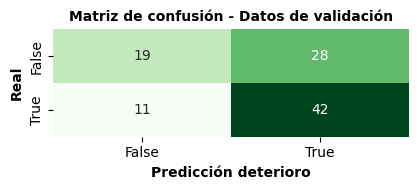

In [13]:
# Evaluar prediccion

print(classification_report(Y_validacion, y_pred))
conf_matrix = confusion_matrix(Y_validacion, y_pred)
class_names = [False, True]
plt.figure(figsize=(8, 2))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción deterioro', fontweight='bold')
plt.ylabel('Real', fontweight='bold')
plt.title('Matriz de confusión - Datos de validación', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()